In [2]:
import numpy as np
from scipy.linalg import eigh
from scipy.linalg import inv

import pandas as pd

### Clamped Free

In [54]:
# Material properties and geometry
E = 207e9      # Modulus of elasticity of mild steel (Pa)
rho = 7860     # Density of mild steel (kg/m^3)
B = 0.05       # Initial breadth of the beam (m)
Bn = 0.03      # Final breadth at the tapered end (m)
T = 0.03       # Initial thickness of the beam (m)
Tn = 0.02      # Final thickness at the tapered end (m)
L = 1.0        # Length of the beam (m)

In [55]:
# Element and shape function formulation
n = 10         # Number of 2D 2DOF elements
l = L / n      # Length of each element (m)

# Rate of tapering in breadth and thickness
tb = (B - Bn) / (2 * L)  # Taper rate for breadth
tt = (T - Tn) / (2 * L)  # Taper rate for thickness

In [56]:
# Initial element stiffness matrix (excluding moment of inertia)
k1 = np.array([[12, 6*l, -12, 6*l],
                [6*l, 4*l**2, -6*l, 2*l**2],
                [-12, -6*l, 12, -6*l],
                [6*l, 2*l**2, -6*l, 4*l**2]])

# Element stiffness matrix scaled by material properties
k = k1 * E / l**3

# Initial element mass matrix
m1 = np.array([[156, 22*l, 54, -13*l],
                [22*l, 4*l**2, 13*l, -3*l**2],
                [54, 13*l, 156, -22*l],
                [-13*l, -3*l**2, -22*l, 4*l**2]])

# Element mass matrix scaled by material properties
m = m1 * rho * l / 420

# Initialize breadth and thickness for iterations
b = B
t = T
p = 0  # Placeholder for any additional parameters (e.g., loading conditions)


In [57]:
# Initialize global stiffness and mass matrices
K = np.zeros(((2 * n) + 2, (2 * n) + 2))  # Global stiffness matrix
M = np.zeros(((2 * n) + 2, (2 * n) + 2))  # Global mass matrix

In [58]:
# Initialize parameters for the assembly process
p = 0
for q in range(n):
    # Calculate tapered dimensions for the current element
    b1 = b - (2 * l * tb)  # New breadth after tapering
    t1 = t - (2 * l * tt)  # New thickness after tapering
    
    # Mean area moment of inertia and element area
    I = ((b + b1) / 2) * (((t + t1) / 2) ** 3) / 12  # Mean area moment of inertia
    A = ((b + b1) / 2) * ((t + t1) / 2)  # Mean element area
    
    # Scale stiffness and mass matrices by the moment of inertia and area
    k2 = k * I
    m2 = m * A

    # Assembly into global stiffness and mass matrices
    for i in range(4):
        for j in range(4):
            K[p + i, p + j] += k2[i, j]  # Add element stiffness to global stiffness
            M[p + i, p + j] += m2[i, j]  # Add element mass to global mass

    # Move to the next element (shift rows and columns by two positions)
    p += 2  
    b = b1  # Update breadth for the next element
    t = t1  # Update thickness for the next element

In [59]:
# Extract relevant submatrices for boundary conditions
K1 = K[:, 1:(2 * n) + 2]  # Trim the first column
K2 = K1[1:(2 * n) + 2, :]  # Trim the first row
K3 = K2[:, 1:(2 * n) + 1]  # Trim the last column
K4 = K3[1:(2 * n) + 1, :]   # Trim the last row

M1 = M[:, 1:(2 * n) + 2]  # Trim the first column
M2 = M1[1:(2 * n) + 2, :]  # Trim the first row
M3 = M2[:, 1:(2 * n) + 1]  # Trim the last column
M4 = M3[1:(2 * n) + 1, :]   # Trim the last row


In [60]:
# Initialize the lower triangular matrix L
L = np.zeros((2 * n, 2 * n))  # Lower triangular matrix for Cholesky decomposition

# First element in the matrix L
l1 = np.sqrt(K4[0, 0])  # Diagonal element calculation
L[0, 0] = l1

# First column of the matrix L
for i in range(1, 2 * n):
    l2 = K4[i, 0] / l1  # Calculate elements for the first column
    L[i, 0] = l2

# Fill in the rest of the lower triangular matrix L
for i in range(1, 2 * n):
    for j in range(i, 2 * n):
        if i == j:
            # Diagonal elements
            s1 = sum((L[i, s]) ** 2 for s in range(i))  # Sum of squares of the previous row elements
            l3 = np.sqrt(K4[i, i] - s1)  # Calculate diagonal element
            L[i, i] = l3
        elif i < j:
            # Off-diagonal elements
            s3 = sum(L[j, s2] * L[i, s2] for s2 in range(i))  # Accumulate products for off-diagonal calculation
            l4 = (K4[i, j] - s3) / L[i, i]  # Calculate off-diagonal element
            L[j, i] = l4  # Assign value to lower triangular matrix


In [61]:
e1v1 = eigenvectors[0]
e1v2 = eigenvectors[1]
e1v3 = eigenvectors[2]
e1v4 = eigenvectors[3]
e1v5 = eigenvectors[4]
e1v6 = eigenvectors[5]

In [62]:
np.mean(e1v1)

0.0034012237138832087

In [63]:
np.mean(e1v2)

0.0005965947325068227

In [64]:
np.mean(e1v3)

0.0003030048092791841

In [65]:
np.mean(e1v4)

0.00016934785763839124

In [66]:
np.mean(e1v5)

0.00011252001444920529

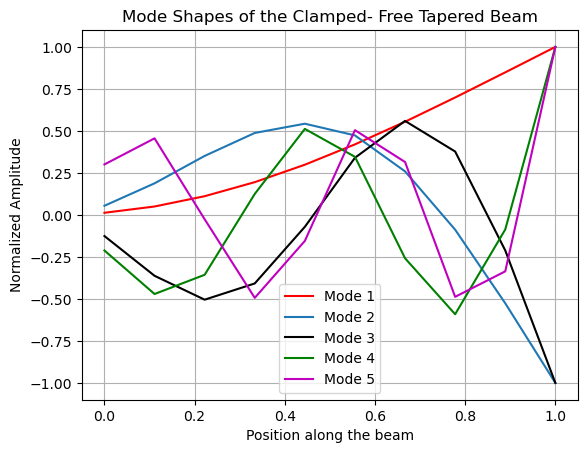

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize arrays to store the normalized mode shapes
ev11 = np.zeros(n)
ev22 = np.zeros(n)
ev33 = np.zeros(n)
ev44 = np.zeros(n)
ev55 = np.zeros(n)
ev66 = np.zeros(n)

# Function to extract every second element and normalize the mode shape
def extract_and_normalize(eigenvector, n):
    """
    Extracts every second element from the eigenvector and normalizes the mode shape.

    Parameters:
        eigenvector (ndarray): The eigenvector representing the mode shape.
        n (int): The number of points for the mode shape.

    Returns:
        ndarray: Normalized mode shape.
    """
    mode_shape = np.zeros(n)
    p = 0
    for i in range(0, 2*n, 2):
        mode_shape[p] = eigenvector[i]
        p += 1
    
    # Normalize the mode shape
    max_val = np.max(np.abs(mode_shape))
    mode_shape_normalized = mode_shape / max_val
    return mode_shape_normalized

# Extract and normalize each mode shape
ev11 = extract_and_normalize(e1v1, n)
ev22 = extract_and_normalize(-e1v2, n)  # negating as per the original code
ev33 = extract_and_normalize(-e1v3, n)
ev44 = extract_and_normalize(e1v4, n)
ev55 = extract_and_normalize(e1v5, n)
ev66 = extract_and_normalize(-e1v6, n)

# Define the x-axis values
x = np.linspace(0, 1, n)

df = pd.DataFrame({'Position':x,
                    'Mode 1': ev11,
                    'Mode 2': ev22,
                    'Mode 3': ev33,
                    'Mode 4': ev44,
                    'Mode 5':ev55})
# df.to_excel('cf_tapered_beam_modes_n_50.xlsx', index=False)

# Plot the normalized mode shapes
plt.plot(x, ev11, 'r', label='Mode 1')
plt.plot(x, ev22, label='Mode 2')
plt.plot(x, ev33, 'k', label='Mode 3')
plt.plot(x, ev44, 'g', label='Mode 4')
plt.plot(x, ev55, 'm', label='Mode 5')
# plt.plot(x, ev66, 'y', label='Mode 6')

plt.xlabel('Position along the beam')
plt.ylabel('Normalized Amplitude')
plt.title('Mode Shapes of the Clamped- Free Tapered Beam')
plt.legend()
plt.grid(True)
plt.show()


### Clamped - Clamped

In [78]:
import numpy as np

# Beam geometry
E = 207e9  # modulus of elasticity of mild steel
rho = 7860  # density of mild steel
B = 0.05  # initial breadth
Bn = 0.03  # tapered final breadth
T = 0.03  # initial thickness
Tn = 0.02  # tapered final thickness
L = 1  # length of the beam

# Element discretization
n = 10  # number of elements
l = L / n  # element length
tb = (B - Bn) / (2 * L)
tt = (T - Tn) / (2 * L)

# Stiffness matrix and mass matrix for an element
k1 = np.array([
    [12, 6 * l, -12, 6 * l],
    [6 * l, 4 * l**2, -6 * l, 2 * l**2],
    [-12, -6 * l, 12, -6 * l],
    [6 * l, 2 * l**2, -6 * l, 4 * l**2]
])
k = k1 * E / (l**3)  # Initial element stiffness matrix excluding area moment of inertia

m1 = np.array([
    [156, 22 * l, 54, -13 * l],
    [22 * l, 4 * l**2, 13 * l, -3 * l**2],
    [54, 13 * l, 156, -22 * l],
    [-13 * l, -3 * l**2, -22 * l, 4 * l**2]
])
m = m1 * rho * l / 420  # Initial element mass matrix

b = B
t = T
p = 0

# Assembly of matrices
K = np.zeros(((2 * n) + 2, (2 * n) + 2))  # Global stiffness matrix
M = np.zeros(((2 * n) + 2, (2 * n) + 2))  # Global mass matrix

for q in range(n):
    b1 = b - (2 * l * tb)
    t1 = t - (2 * l * tt)
    I = ((b + b1) / 2) * (((t + t1) / 2)**3) / 12  # Mean area moment of inertia
    A = ((b + b1) / 2) * ((t + t1) / 2)  # Mean area of an element
    k2 = k * I
    m2 = m * A
    
    for i in range(4):
        for j in range(4):
            K[p + i, p + j] += k2[i, j]
            M[p + i, p + j] += m2[i, j]
    
    # Moving to the next element
    p += 2
    b = b1
    t = t1

K1 = K[:, 2:((2 * n) + 2)]
K2 = K1[2:((2 * n) + 2), :]
K3 = K2[:, :((2 * n) - 2)]
K4 = K3[:((2 * n) - 2), :]

M1 = M[:, 2:((2 * n) + 2)]
M2 = M1[2:((2 * n) + 2), :]
M3 = M2[:, :((2 * n) - 2)]
M4 = M3[:((2 * n) - 2), :]

In [79]:
# TRIANGULARIZATION OF STIFFNESS MATRIX
L = np.zeros(((2 * n) - 2, (2 * n) - 2))
l1 = np.sqrt(K4[0, 0])
L[0, 0] = l1
s1 = 0
s3 = 0

for i in range(1, (2 * n) - 2):
    l2 = K4[i, 0] / l1
    L[i, 0] = l2

for i in range(1, (2 * n) - 2):
    for j in range(i, (2 * n) - 2):
        if i == j:
            s1 = np.sum(L[i, :i]**2)
            l3 = np.sqrt(K4[i, i] - s1)
            L[i, i] = l3
        if i < j:
            s3 = np.sum(L[j, :i] * L[i, :i])
            l4 = (K4[i, j] - s3) / L[i, i]
            L[j, i] = l4

# SIMULTANEOUS ITERATION PROCESS
U = np.zeros(((2 * n) - 2, 6))
np.fill_diagonal(U[:6, :6], 1)

for _ in range(10):
    X = np.linalg.inv(L.T) @ U
    Y = M4 @ X
    V = np.linalg.inv(L) @ Y
    D = (V.T @ V)

    J = np.zeros((6, 6))
    l1 = np.sqrt(D[0, 0])
    J[0, 0] = l1
    s1 = 0
    s3 = 0

    for i in range(1, 6):
        l2 = D[i, 0] / l1
        J[i, 0] = l2

    for i in range(1, 6):
        for j in range(i, 6):
            if i == j:
                s1 = np.sum(J[i, :i]**2)
                l3 = np.sqrt(D[i, i] - s1)
                J[i, i] = l3
            if i < j:
                s3 = np.sum(J[j, :i] * J[i, :i])
                l4 = (D[i, j] - s3) / J[i, i]
                J[j, i] = l4

    U = V @ np.linalg.inv(J.T)

# Check if eigenvalues are non-negative before taking the square root
def safe_sqrt(x, epsilon=1e-10):
    return np.sqrt(np.maximum(x, epsilon))

# Check for non-negative eigenvalues
eigenvalues_B1 = np.diag(B1)
frequencies = safe_sqrt(1 / eigenvalues_B1)

# Calculate mode shapes
U1 = np.linalg.inv(L.T) @ U
eigenvectors = [U1[:, i] for i in range(6)]

# Calculate natural frequencies using eigs from scipy
A2 = np.linalg.inv(K4) @ M4
eigenvalues, eigenvectors_scipy = eigh(A2)

# Check for non-negative eigenvalues
frequencies_scipy = safe_sqrt(1 / eigenvalues)
eigenvectors_scipy = [eigenvectors_scipy[:, i] for i in range(len(eigenvalues))]

In [80]:
e1v1 = eigenvectors[0]
e1v2 = eigenvectors[1]
e1v3 = eigenvectors[2]
e1v4 = eigenvectors[3]
e1v5 = eigenvectors[4]
e1v6 = eigenvectors[5]

In [81]:
np.mean(e1v1)

0.0002119772551541946

In [82]:
np.mean(e1v2)

2.6937948061376403e-05

In [83]:
np.mean(e1v3)

2.6096566553151228e-05

In [84]:
np.mean(e1v4)

2.2225279314711332e-05

In [85]:
np.mean(e1v5)

1.363989957124525e-05

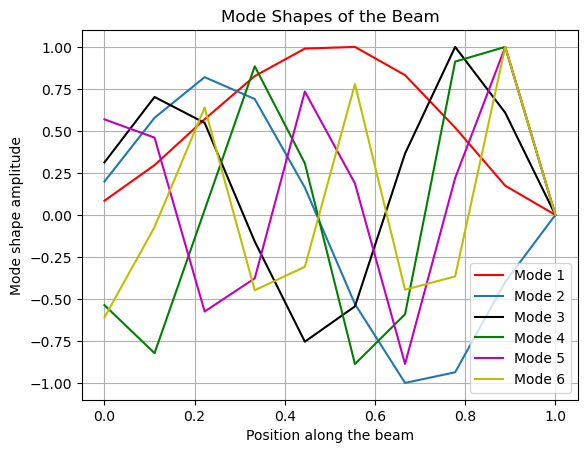

In [86]:
# Initialize arrays for mode shapes
ev11 = np.zeros(n)
ev22 = np.zeros(n)
ev33 = np.zeros(n)
ev44 = np.zeros(n)
ev55 = np.zeros(n)
ev66 = np.zeros(n)

# Populate mode shapes
p = 0
for i in range(0, (2 * n) - 2, 2):
    ev11[p] += e1v1[i]
    p += 1
ev11[n - 1] = 0

a = np.max(np.abs(ev11))
ev111 = ev11 / a
x = np.linspace(0, 1, n)
plt.plot(x, ev111, 'r')

p = 0
for i in range(0, (2 * n) - 2, 2):
    ev22[p] -= e1v2[i]
    p += 1
ev22[n - 1] = 0

a = np.max(np.abs(ev22))
ev222 = ev22 / a
plt.plot(x, ev222)

p = 0
for i in range(0, (2 * n) - 2, 2):
    ev33[p] += e1v3[i]
    p += 1
ev33[n - 1] = 0

a = np.max(np.abs(ev33))
ev333 = ev33 / a
plt.plot(x, ev333, 'k')

p = 0
for i in range(0, (2 * n) - 2, 2):
    ev44[p] += e1v4[i]
    p += 1
ev44[n - 1] = 0

a = np.max(np.abs(ev44))
ev444 = ev44 / a
plt.plot(x, ev444, 'g')

p = 0
for i in range(0, (2 * n) - 2, 2):
    ev55[p] += e1v5[i]
    p += 1
ev55[n - 1] = 0

a = np.max(np.abs(ev55))
ev555 = ev55 / a
plt.plot(x, ev555, 'm')

p = 0
for i in range(0, (2 * n) - 2, 2):
    ev66[p] += e1v6[i]
    p += 1
ev66[n - 1] = 0

a = np.max(np.abs(ev66))
ev666 = ev66 / a
plt.plot(x, ev666, 'y')

# Show the plot
plt.xlabel('Position along the beam')
plt.ylabel('Mode shape amplitude')
plt.title('Mode Shapes of the Beam')
plt.legend(['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6'])
plt.grid(True)
plt.show()


In [87]:
df = pd.DataFrame({'Position':x,
                    'Mode 1': ev11,
                    'Mode 2': ev22,
                    'Mode 3': ev33,
                    'Mode 4': ev44,
                    'Mode 5':ev55})
# df.to_excel('cc_tapered_beam_modes_n_50.xlsx', index=False)